# Immune summary

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from itertools import product

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import os

In [3]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [4]:
PATH = os.path.expanduser('~/data/2023_Immune')
! mkdir -p {PATH}/pics

IMMUNE_CELLS = ['BCell', 'TCell', 'Monocyte']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']

In [5]:
def load_bams(path):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'mapped_reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in IMMUNE_CELLS if c in f), None)
        mod = next((m for m in MODIFICATIONS + ['Control'] if m in f), None)
        if cell and mod:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, reads)
    return df_bams

bams_df = load_bams(PATH + '/bams')
bams_df

  0%|          | 0/113 [00:00<?, ?it/s]

,bam_file,modification,cell,mapped_reads
0,/home/jetbrains/data/2023_Immune/bams/TCell_Co...,Control,TCell,35331343
1,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K27ac,BCell,21067933
2,/home/jetbrains/data/2023_Immune/bams/TCell_H3...,H3K4me3,TCell,28746534
3,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K4me1,BCell,28811580
4,/home/jetbrains/data/2023_Immune/bams/TCellBB_...,H3K4me3,TCell,3902197
5,/home/jetbrains/data/2023_Immune/bams/TCellBB_...,H3K4me3,TCell,2963533
6,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K36me3,BCell,22597809
7,/home/jetbrains/data/2023_Immune/bams/Monocyte...,H3K27me3,Monocyte,22268131
8,/home/jetbrains/data/2023_Immune/bams/BCell_Co...,Control,BCell,29198392
9,/home/jetbrains/data/2023_Immune/bams/TCellBB_...,Control,TCell,6505287


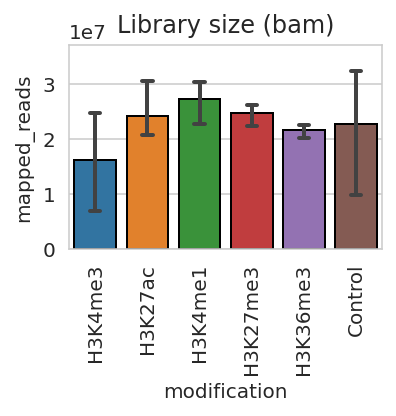

In [6]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.barplot(data=bams_df, x='modification', y='mapped_reads', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        order=MODIFICATIONS + ['Control'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Library size (bam)')
ax.set_ylim(0, 3.7e7)
plt.tight_layout()
plt.savefig(PATH + f'/pics/library_mapped_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

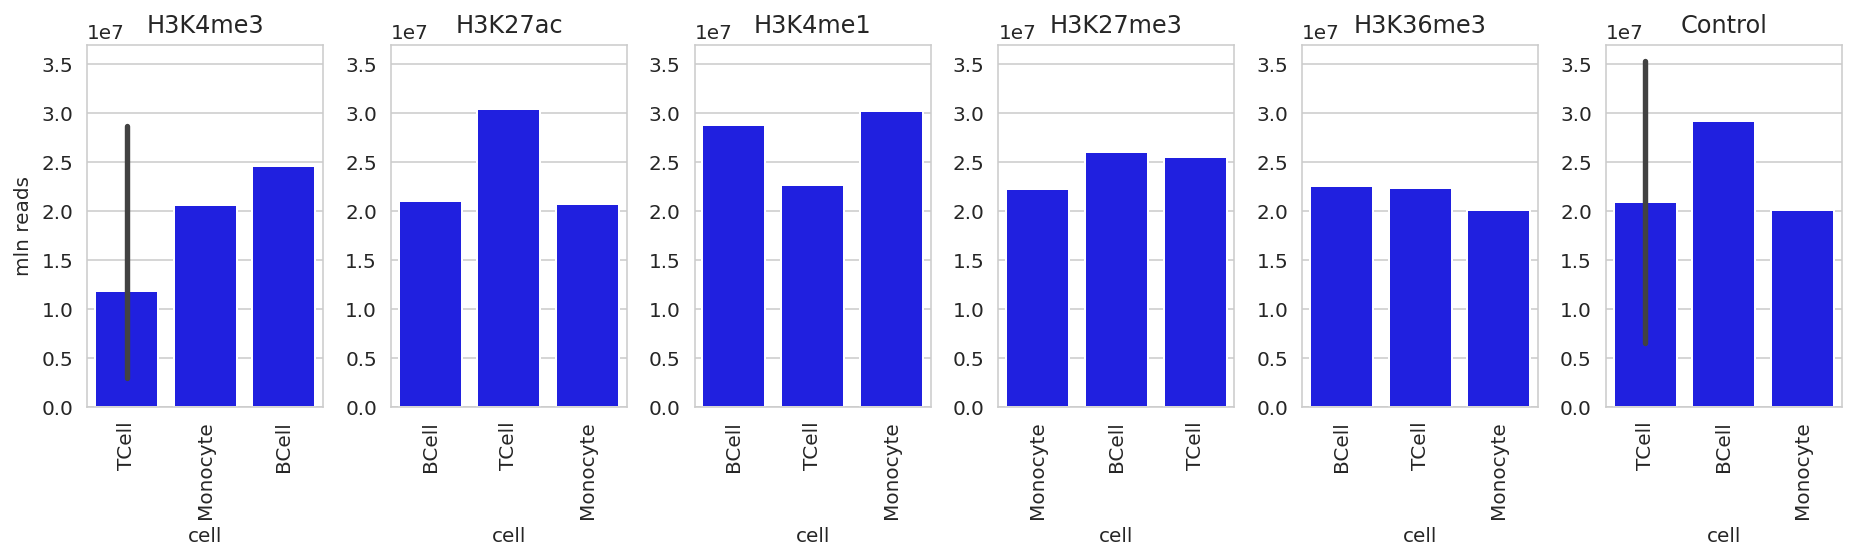

In [7]:
plt.figure(figsize=(13, 4))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'Control'] ):
    ax = axs[i]
    g_results = sns.barplot(data=bams_df[bams_df['modification'] == m], x='cell', y='mapped_reads', ax=ax, color='blue')
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('mln reads')
    ax.set_ylim(0, 3.7e7)
plt.tight_layout()
plt.savefig(PATH + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# SPAN signal to noise and frip estimation

In [7]:
def load_span_logs(logs_path):
    df_span = pd.DataFrame(columns=['log_file', 'modification', 'cell', 'signal-to-noise', 'frip'], dtype=object)
    for f in tqdm(os.listdir(logs_path)):
        if not f.endswith('.log'):
            continue
        cell = next((c for c in IMMUNE_CELLS if c in f), None)
        mod = next((m for m in MODIFICATIONS if m in f), None)
        if cell and mod:
            file = os.path.join(logs_path, f)
            out = ! cat {file} | grep "Signal to noise:"
            sn = float(out[0].replace('Signal to noise: ', ''))
            out = ! cat {file} | grep "FRIP:"
            frip = float(out[0].replace('FRIP: ', ''))
            df_span.loc[len(df_span)] = (file, mod, cell, sn, frip)
    return df_span

df_span = load_span_logs(PATH + '/logs/span')
df_span

  0%|          | 0/14 [00:00<?, ?it/s]

,log_file,modification,cell,signal-to-noise,frip
0,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K4me3,TCell,26.919481,0.421268
1,/home/jetbrains/data/2023_Immune/logs/span/BCe...,H3K4me3,BCell,21.315690,0.325058
2,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K36me3,TCell,3.579916,0.621348
3,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K27ac,TCell,9.028337,0.347180
4,/home/jetbrains/data/2023_Immune/logs/span/Mon...,H3K4me3,Monocyte,48.057697,0.453702
5,/home/jetbrains/data/2023_Immune/logs/span/BCe...,H3K27me3,BCell,1.682106,0.376869
6,/home/jetbrains/data/2023_Immune/logs/span/Mon...,H3K27me3,Monocyte,5.847326,0.408112
7,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K27me3,TCell,2.348546,0.407297
8,/home/jetbrains/data/2023_Immune/logs/span/Mon...,H3K36me3,Monocyte,10.704506,0.722326
9,/home/jetbrains/data/2023_Immune/logs/span/BCe...,H3K4me1,BCell,7.991414,0.608582


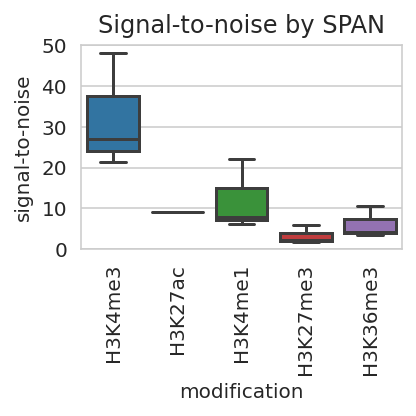

In [8]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=df_span,
                        x='modification', y='signal-to-noise',
                        order=MODIFICATIONS,
                        showfliers=False)
ax = g_results.axes
ax.set_title('Signal-to-noise by SPAN')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(0, 50)
plt.tight_layout()
plt.savefig(PATH + f'/pics/signal_to_noise_span_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

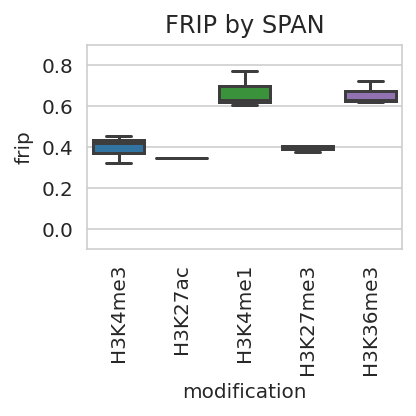

In [9]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=df_span,
                        x='modification', y='frip',
                        order=MODIFICATIONS,
                        showfliers=False)
ax = g_results.axes
ax.set_title('FRIP by SPAN')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim(-0.1, 0.9)
plt.tight_layout()
plt.savefig(PATH + f'/pics/frip_span_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# FRIP datatables

In [10]:
# Load frip datasets
ts = []
for m in MODIFICATIONS:
    t = pd.read_csv(f'{PATH}/pics/{m}_frip.csv.gz', compression='gzip')
    t['modification'] = m
    ts.append(t)

frip_df_all = pd.concat(ts).reset_index(drop=True)
del t
del ts
frip_df_all.sample(5)

,cell,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads,frip,peaks_rpkm,peaks_background_log2fc,peaks_control_log2fc,modification
6,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,MACS2 broad,/tmp/tmp5_x3l9io,28929,35746467,3.523716e+07,8.489682e+07,1.257078e+06,8.485019e+07,0.415059,11.611180,5.921089,4.808159,H3K4me3
43,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K3...,SPAN,/tmp/tmp94dc91pa,42693,381441369,5.330747e+07,8.492705e+07,1.335214e+07,8.484955e+07,0.627685,1.645562,3.580599,1.995950,H3K36me3
13,BCell,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,MACS2,/tmp/tmphu8jr_7q,45626,40038619,2.707811e+07,8.488214e+07,1.582062e+06,8.483880e+07,0.319008,7.967516,5.156401,4.096512,H3K27ac
5,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,SICER,/tmp/tmp6141i3bp,21785,53215015,3.656636e+07,8.489682e+07,1.945063e+06,8.482415e+07,0.430715,8.093869,5.431338,4.231393,H3K4me3
17,TCell,/home/jetbrains/data/2023_Immune/bw/TCell_H3K2...,MACS2,/tmp/tmpadnwn25n,57350,55101554,2.620481e+07,8.490978e+07,2.099982e+06,8.488194e+07,0.308620,5.600922,4.618946,3.640910,H3K27ac


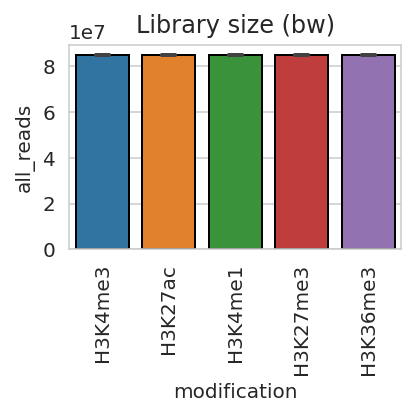

In [11]:
plt.figure(figsize=(3, 3))
ax = plt.axes()
g_results = sns.barplot(data=frip_df_all, x='modification', y='all_reads', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        order=MODIFICATIONS)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Library size (bw)')
plt.tight_layout()
plt.savefig(PATH + f'/pics/library_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

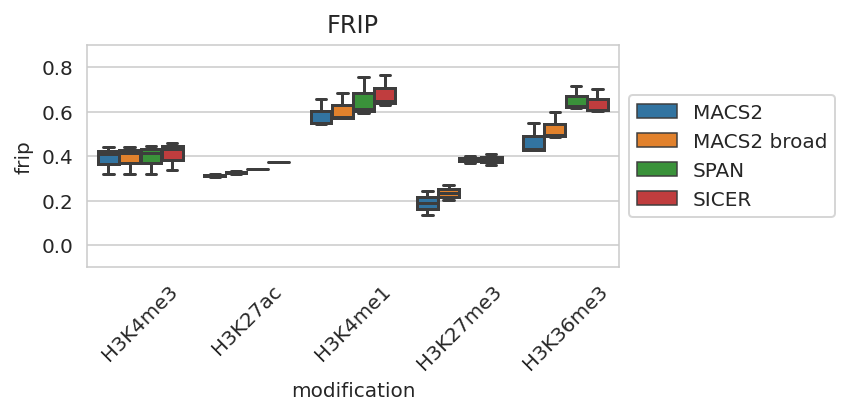

In [12]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='frip', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('FRIP')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.1, 0.9)
plt.tight_layout()
plt.savefig(PATH + f'/pics/frip_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

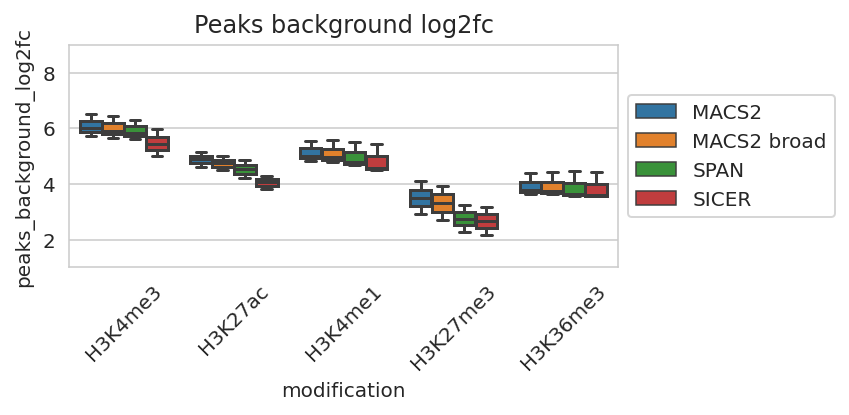

In [13]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='peaks_background_log2fc', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Peaks background log2fc')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(1, 9)
plt.tight_layout()
plt.savefig(PATH + f'/pics/peaks_background_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

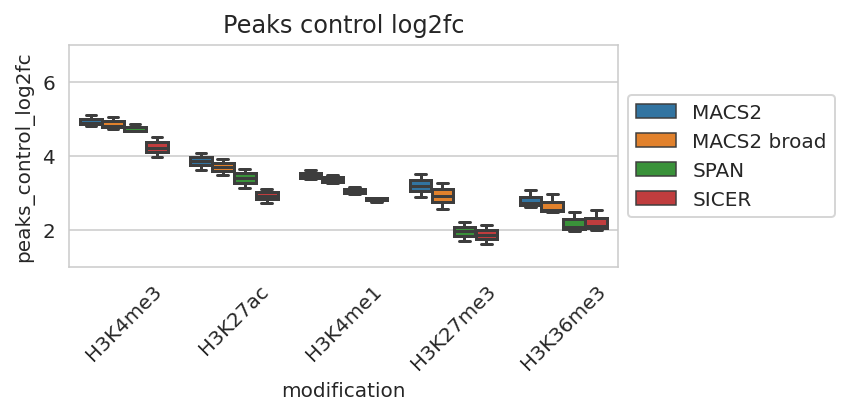

In [14]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=frip_df_all,
                        x='modification', y='peaks_control_log2fc', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Peaks control log2fc')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(1, 7)
plt.tight_layout()
plt.savefig(PATH + f'/pics/peaks_control_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [32]:
df_span.rename({'frip': 'span-frip'}, axis=1, inplace=True)
t = frip_df_all[frip_df_all['tool'] == 'SPAN'].copy()
t = pd.merge(left=df_span, right=t, left_on=['cell', 'modification'], right_on=['cell', 'modification'])
t.sample(5)

,log_file,modification,cell,signal-to-noise,span-frip,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads,frip,peaks_rpkm,peaks_background_log2fc,peaks_control_log2fc
12,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K4me1,TCell,6.191658,0.629038,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,SPAN,/tmp/tmpgcpc7_uz,94649,166428319,5.192860e+07,8.492514e+07,5.794472e+06,8.488192e+07,0.611463,3.674033,4.788128,3.163046
6,/home/jetbrains/data/2023_Immune/logs/span/Mon...,H3K27me3,Monocyte,5.847326,0.408112,/home/jetbrains/data/2023_Immune/bw/Monocyte_H...,SPAN,/tmp/tmpmeyp68p4,47143,203461471,3.416000e+07,8.490034e+07,7.307461e+06,8.481546e+07,0.402354,1.977544,3.254831,2.223423
10,/home/jetbrains/data/2023_Immune/logs/span/BCe...,H3K27ac,BCell,9.066143,0.345494,/home/jetbrains/data/2023_Immune/bw/BCell_H3K2...,SPAN,/tmp/tmprazv459z,26454,54383677,2.892561e+07,8.491408e+07,2.275276e+06,8.490550e+07,0.340646,6.263748,4.849075,3.668089
0,/home/jetbrains/data/2023_Immune/logs/span/TCe...,H3K4me3,TCell,26.919481,0.421268,/home/jetbrains/data/2023_Immune/bw/TCell_H3K4...,SPAN,/tmp/tmpxmleavlx,25006,37976697,3.533556e+07,8.489682e+07,1.370846e+06,8.490275e+07,0.416218,10.959820,5.839606,4.688083
8,/home/jetbrains/data/2023_Immune/logs/span/BCe...,H3K4me1,BCell,7.991414,0.608582,/home/jetbrains/data/2023_Immune/bw/BCell_H3K4...,SPAN,/tmp/tmpe1gl6lwd,89375,166650199,5.053932e+07,8.493336e+07,6.107937e+06,8.491783e+07,0.595047,3.570633,4.687129,3.048385


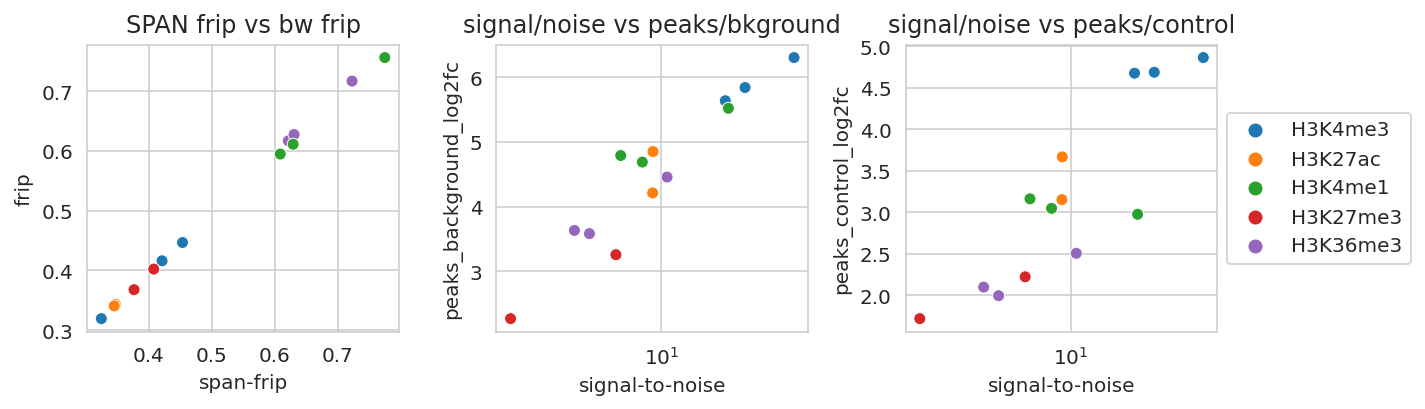

In [43]:
plt.figure(figsize=(10, 3))
axes = [plt.subplot(1, 3, i+1) for i in range(3)]

ax = axes[0]
sns.scatterplot(t, x='span-frip', y='frip', hue='modification', hue_order=MODIFICATIONS, ax=ax)
ax.set_title('SPAN frip vs bw frip')
ax.legend().set_visible(False)

ax = axes[1]
sns.scatterplot(t, x='signal-to-noise', y='peaks_background_log2fc', hue='modification', hue_order=MODIFICATIONS, ax=ax)
ax.set_xscale('log')
ax.set_title('signal/noise vs peaks/bkground')
ax.legend().set_visible(False)

ax = axes[2]
sns.scatterplot(t, x='signal-to-noise', y='peaks_control_log2fc', hue='modification', hue_order=MODIFICATIONS, ax=ax)
ax.set_xscale('log')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('signal/noise vs peaks/control')

plt.tight_layout()
plt.savefig(PATH + f'/pics/span_vs_bw_log2fc_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# END